### Generate the estimated gravitational waveform and calculate the signal-to-noise for GW151226 ###

In [1]:
import sys
!{sys.executable} -m pip install pycbc lalsuite ligo-common --no-cache-dir

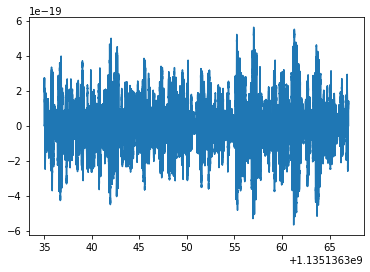

In [2]:
%matplotlib inline
import pylab
# Import the functions we need for later!
from pycbc.catalog import Merger
from pycbc.filter import highpass_fir, matched_filter
from pycbc.waveform import get_td_waveform, taper_timeseries
from pycbc.psd import welch, interpolate

# Read the Hanford data and remove low frequency content
h1 = Merger("GW151226").strain("H1")
h1 = highpass_fir(h1, 15, 16)

# Can you spot where the signal is beforehand?
pylab.plot(h1.sample_times, h1)

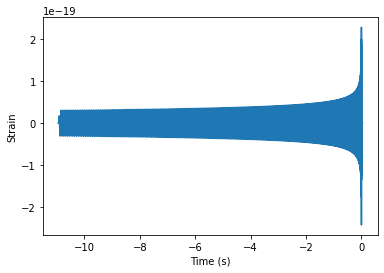

In [3]:
# Generate a waveform similar to GW151226
# Make a template from the public parameters from the LOSC and filter 
# the data to get the phase difference.
z = 0.09
m1 = 14.2 * (1 + z) 
m2 = 7.5 * (1 + z)
s1 = s2 = 0.2

# The frequency to start generating the waveform
fstart = 15.0
hp, hc = get_td_waveform(approximant="SEOBNRv2",
                         mass1=m1, mass2=m2, spin1z=s1, spin2z=s2,
                         f_lower=fstart,
                         delta_t=h1.delta_t)
hp = taper_timeseries(hp, tapermethod='start')

# Move the waveform so that the merge is about at the end
# This means that an SNR spike later on in the data lines up with this point
pylab.plot(hp.sample_times, hp)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

hp.resize(len(h1))
hp.roll(int(hp.start_time * hp.sample_rate))

Text(0.5, 0, 'Frequency (Hz)')

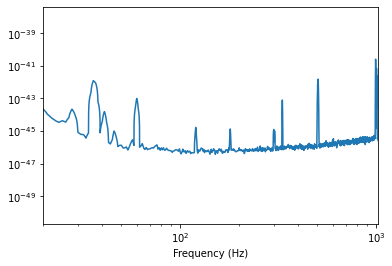

In [4]:
# Estimate the noise spectrum
# Normally we use more data to estimate the psd, but this is illustrative
psd = interpolate(welch(h1), 1.0 / h1.duration)

pylab.loglog(psd.sample_frequencies, psd)
pylab.xlim(20, 1024)
pylab.xlabel('Frequency (Hz)')

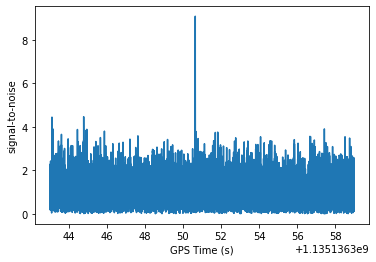

In [11]:
# Calculate the complex Signal-to-noise. This is a complex vector
# because the signal could have any phase.
snr = matched_filter(hp, h1, psd=psd, low_frequency_cutoff=30.0)

# Remove regions corrupted by filter wraparound
snr = snr[len(snr) // 4: len(snr) * 3 // 4]

# Now you should be able to spot where the signal is!
pylab.figure()
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('signal-to-noise')
pylab.xlabel('GPS Time (s)')
pylab.show()

--2020-06-27 14:34:13--  https://losc.ligo.org/s/events/GW151226/L-L1_LOSC_4_V2-1135136334-32.gwf
Resolving losc.ligo.org (losc.ligo.org)... 131.215.113.73
Connecting to losc.ligo.org (losc.ligo.org)|131.215.113.73|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.gw-openscience.org/s/events/GW151226/L-L1_LOSC_4_V2-1135136334-32.gwf [following]
--2020-06-27 14:34:14--  https://www.gw-openscience.org/s/events/GW151226/L-L1_LOSC_4_V2-1135136334-32.gwf
Resolving www.gw-openscience.org (www.gw-openscience.org)... 131.215.113.73
Connecting to www.gw-openscience.org (www.gw-openscience.org)|131.215.113.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1013363 (990K)
Saving to: ‘L-L1_LOSC_4_V2-1135136334-32.gwf’

L-L1_LOSC_4_V2-1135 100%[===================>] 989.61K   616KB/s    in 1.6s    

2020-06-27 14:34:17 (616 KB/s) - ‘L-L1_LOSC_4_V2-1135136334-32.gwf’ saved [1013363/1013363]



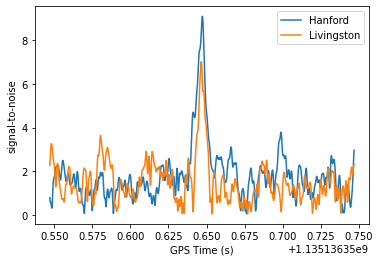

In [15]:
from pycbc.frame import read_frame
# Now let's see what the SNR timeseries looks like in the other detector in Livingston.
# Get the data for L1 from the LOSC site
!wget -O L-L1_LOSC_4_V2-1135136334-32.gwf https://losc.ligo.org/s/events/GW151226/L-L1_LOSC_4_V2-1135136334-32.gwf

# Read the Lvingston data and remove low frequency content
l1 = read_frame('L-L1_LOSC_4_V2-1135136334-32.gwf', 'L1:LOSC-STRAIN')
l1 = highpass_fir(l1, 15, 16)
l1_psd = interpolate(welch(l1), 1.0 / l1.duration)
l1_snr = matched_filter(hp, l1, psd=l1_psd, low_frequency_cutoff=30.0)
l1_snr = l1_snr[len(l1_snr) // 4: len(l1_snr)* 3 // 4]

# Let's look closer around the L1 peak
time = snr.sample_times[snr.abs_arg_max()]
snr = snr.time_slice(time-.1, time+.1)
l1_snr = l1_snr.time_slice(time-.1, time+.1)

# There is a SNR peak near the same time!
pylab.figure()
pylab.plot(snr.sample_times, abs(snr), label='Hanford')
pylab.plot(l1_snr.sample_times, abs(l1_snr), label='Livingston')
pylab.ylabel('signal-to-noise')
pylab.xlabel('GPS Time (s)')
pylab.legend()
pylab.show()